### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [11]:


import numpy as np
import pandas as pd

In [12]:
data = pd.read_csv("Data/processed_train.csv")

In [13]:
data.shape

(119952, 79)

In [14]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [15]:
### Your code is here

data.groupby('HasDetections').count().T.iloc[0].rename('count')

HasDetections
0    99940
1    20012
Name: count, dtype: int64

Произведем процедуру отложенной выборки:

In [16]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [17]:
### Your code is here

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(penalty='l2', C=0.01))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(C=0.01))])

In [18]:
print("Train:")
print(classification_report(y_train, pipe.predict(X_train), digits=3))

Train:
              precision    recall  f1-score   support

           0      0.847     0.988     0.912     74921
           1      0.651     0.109     0.187     15043

    accuracy                          0.841     89964
   macro avg      0.749     0.549     0.549     89964
weighted avg      0.814     0.841     0.791     89964



In [19]:
print("Test:")
print(classification_report(y_test, pipe.predict(X_test), digits=3))

Test:
              precision    recall  f1-score   support

           0      0.848     0.988     0.913     25019
           1      0.643     0.106     0.182      4969

    accuracy                          0.842     29988
   macro avg      0.746     0.547     0.547     29988
weighted avg      0.814     0.842     0.792     29988



Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [20]:
pipe.fit(X_train, y_train)
pred_test = pipe.predict(X_test)

### Your code is here

tn = sum((pred_test == 0) & (y_test == 0))
tp = sum((pred_test == 1) & (y_test == 1))
fp = sum((pred_test == 1) & (y_test == 0))
fn = sum((pred_test == 0) & (y_test == 1))

tn, fp, fn, tp

(24727, 292, 4442, 527)

In [21]:
### Your code is here

from sklearn.metrics import confusion_matrix

tp_fp, fn_tn = confusion_matrix(y_test, pred_test)

tn, fp = tp_fp
fn, tp = fn_tn

tn, fp, fn, tp

(24727, 292, 4442, 527)

**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [22]:
### Your code is here
acc = (tp + tn) / (tp + tn + fp + fn)
acc.round(3)

0.842

Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [23]:
### Your code is here

precision = tp / (tp + fp)
recall = tp / (tp + fn)

precision.round(3), recall.round(3)

(0.643, 0.106)

Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [24]:
### Your code is here

predictions = pd.DataFrame(pipe.predict_proba(X_test) > 0.5)

result = predictions.apply(lambda x: 0 if x[0] else 1, axis=1).rename('result')
result

0        0
1        0
2        0
3        0
4        0
        ..
29983    1
29984    0
29985    0
29986    0
29987    0
Name: result, Length: 29988, dtype: int64

In [25]:
y_test.reset_index(drop=True, inplace=True)

In [26]:
tn = sum((result == 0) & (y_test == 0))
tp = sum((result == 1) & (y_test == 1))
fp = sum((result == 1) & (y_test == 0))
fn = sum((result == 0) & (y_test == 1))

tn, fp, fn, tp

(24727, 292, 4442, 527)

**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [27]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

pred_probs = pipe.predict_proba(X_test)

precision, recall, threshold = precision_recall_curve(y_test, pred_probs[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precision:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {threshold[ind][-1]}")

Precison:	 0.6003734827264239
Recall: 	 0.12940229422418997
Threshold:	 0.45894877437904347


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [359]:
### Your code is here

ind = np.where(precision == precision[recall > 0.2].max())

print(f"Precision:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {threshold[ind][-1]}")

Precision:	 0.4928182268449728
Recall: 	 0.20024149728315557
Threshold:	 0.33128525155255817


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [371]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0.001, 1.1, 100)
y = np.linspace(0.001, 1.1, 100)


def level_lines(func, name):
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)

    # X - Recall
    # Y - Precision

    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    contour = plt.contour(X, Y, Z, 15, cmap='plasma')
    plt.clabel(contour, inline=True, fontsize=8)


def plot_3d(func, recall, precision):
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)

    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    ax.scatter(X, Y, Z,
               s=1,
               c=X,
               marker='.',
               alpha=0.5,
               cmap='plasma')
    plt.contour(X, Y, Z, 15, cmap='plasma')

    arithm_idx = (func(precision, recall)).argmax()

    highlight_x = recall[arithm_idx]
    highlight_y = precision[arithm_idx]
    highlight_z = func(recall, precision)[arithm_idx]

    print(f'Dot - ({highlight_x:.3f}, {highlight_y:.3f}, {highlight_z:.3f})')

    ax.scatter(highlight_x,
               highlight_y,
               highlight_z,
               color='crimson',
               s=50,
               zorder=5000)

    ax.scatter(highlight_x, highlight_y, 0, color='green', s=100, marker='1', label="XY Plane Projection")

    ax.set_box_aspect([1, 1, 1])

Precision:	 0.17
Recall: 	 0.998
Metric_func:	 0.584
Threshold:	 0.022

Dot - (0.998, 0.170, 0.584)


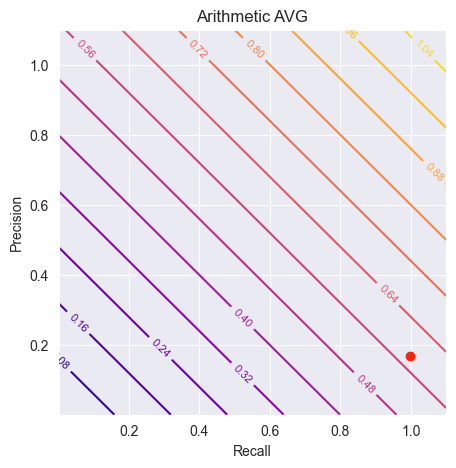

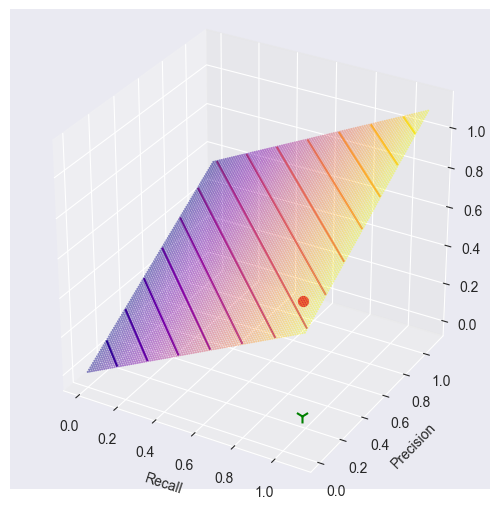

In [381]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y) / 2

metric_idx = (metric_func(recall, precision)).argmax()

print(f"Precision:\t {precision[metric_idx].round(3)}")
print(f"Recall: \t {recall[metric_idx].round(3)}")
print(f"Metric_func:\t {metric_func(recall, precision)[metric_idx].round(3)}")
print(f"Threshold:\t {threshold[metric_idx].round(3)}\n")


level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[metric_idx], precision[metric_idx], color='#FF2400', marker='o')

plot_3d(metric_func, recall, precision)

Precision:	 0.224
Recall: 	 0.809
Geom_func:	 0.426
Threshold:	 0.126

Dot - (0.809, 0.224, 0.426)


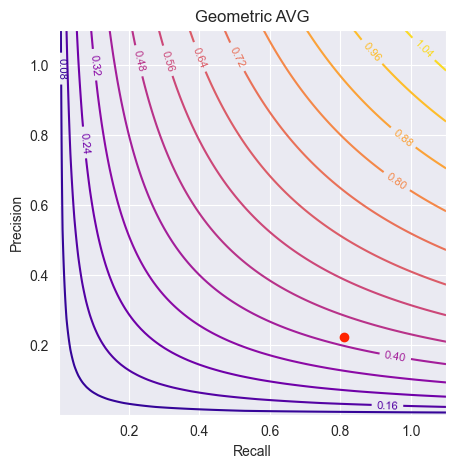

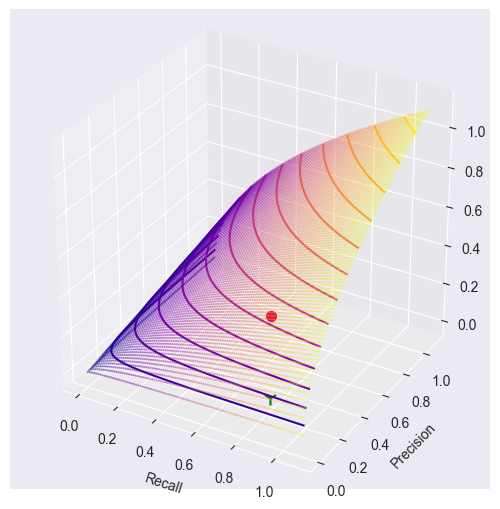

In [380]:
### Повторите для среднего геометрического
### Your code is here

geom_func = lambda x, y: np.sqrt(x * y)

geom_idx = (geom_func(recall, precision)).argmax()

print(f"Precision:\t {precision[geom_idx].round(3)}")
print(f"Recall: \t {recall[geom_idx].round(3)}")
print(f"Geom_func:\t {geom_func(recall, precision)[geom_idx].round(3)}")
print(f"Threshold:\t {threshold[geom_idx].round(3)}\n")

level_lines(geom_func, "Geometric AVG")
plt.plot(recall[geom_idx], precision[geom_idx], color='#FF2400', marker='o')

plot_3d(geom_func, recall, precision)

Precision:	 0.359
Recall: 	 0.359
Min_func:	 0.359
Threshold:	 0.237

Dot - (0.359, 0.359, 0.359)


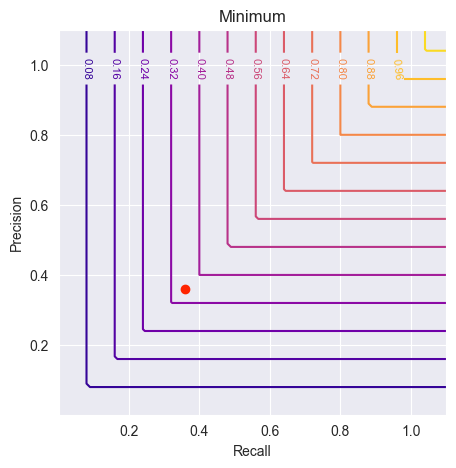

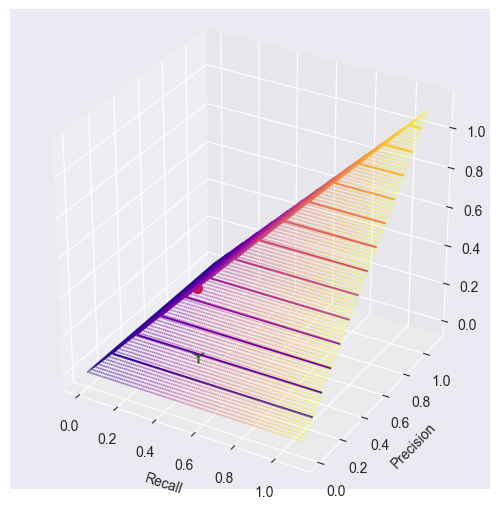

In [379]:
### Повторите для минимума
### Your code is here

min_func = lambda x, y: np.minimum(x, y)

min_idx = (min_func(recall, precision)).argmax()

print(f"Precision:\t {precision[min_idx].round(3)}")
print(f"Recall: \t {recall[min_idx].round(3)}")
print(f"Min_func:\t {min_func(recall, precision)[min_idx].round(3)}")
print(f"Threshold:\t {threshold[min_idx].round(3)}\n")

level_lines(min_func, "Minimum")
plt.plot(recall[min_idx], precision[min_idx], color='#FF2400', marker='o')

plot_3d(min_func, recall, precision)

**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

Precision:	 0.285
Recall: 	 0.524
Threshold:	 0.193
F-1:	 0.369
Dot - (0.524, 0.285, 0.369)


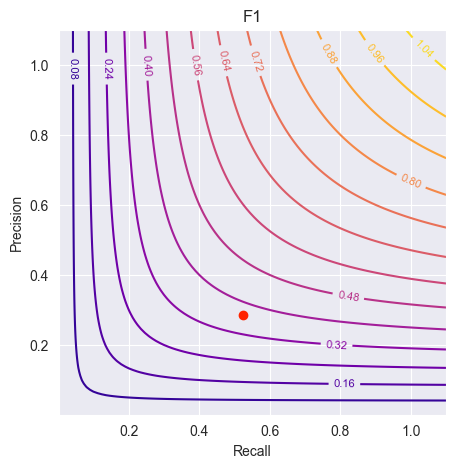

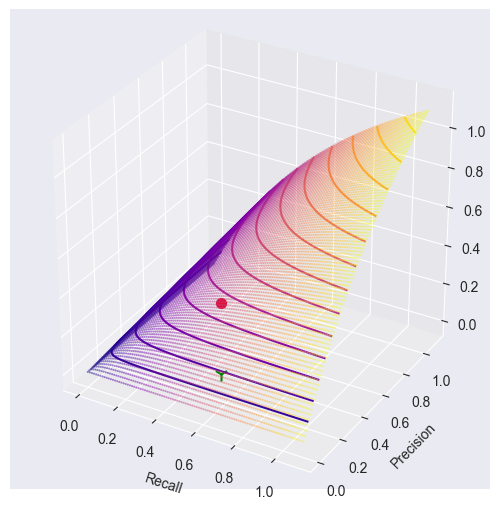

In [391]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold
### Your code is here


### Повторите для минимума
### Your code is here

f1 = lambda x, y: (2 * x * y) / (x + y)

f1_idx = (f1(recall, precision)).argmax()

print(f"Precision:\t {precision[f1_idx].round(3)}")
print(f"Recall: \t {recall[f1_idx].round(3)}")
print(f"Threshold:\t {threshold[f1_idx].round(3)}")
print(f"F-1:\t {f1(recall, precision)[f1_idx].round(3)}")

level_lines(f1, "F1")
plt.plot(recall[f1_idx], precision[f1_idx], color='#FF2400', marker='o')

plot_3d(f1, recall, precision)

Precision:	 0.643
Recall: 	 0.109
Threshold:	 0.497
F-0.05:	 0.521
Dot - (0.996, 0.172, 0.179)


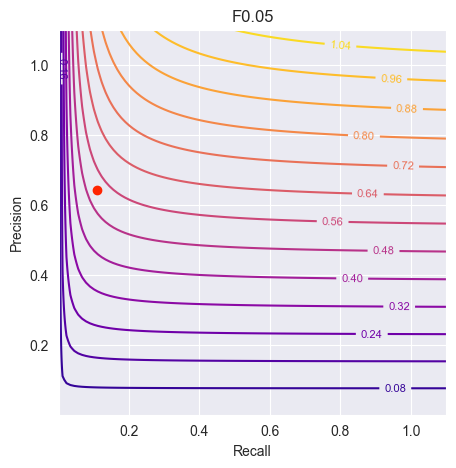

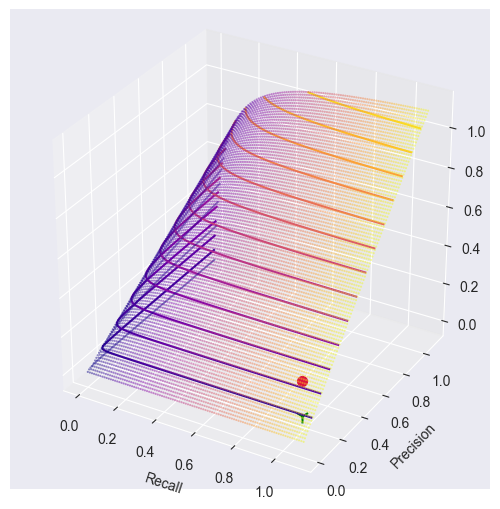

In [392]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here


f005 = lambda x, y: (1.05 * x * y) / (x + 0.05 * y)

f005_idx = (f005(recall, precision)).argmax()

print(f"Precision:\t {precision[f005_idx].round(3)}")
print(f"Recall: \t {recall[f005_idx].round(3)}")
print(f"Threshold:\t {threshold[f005_idx].round(3)}")
print(f"F-0.05:\t {f005(recall, precision)[f005_idx].round(3)}")

level_lines(f005, "F0.05")
plt.plot(recall[f005_idx], precision[f005_idx], color='#FF2400', marker='o')

plot_3d(f005, recall, precision)

Precision:	 0.211
Recall: 	 0.86
Threshold:	 0.109
F-4:	 0.532
Dot - (0.210, 0.482, 0.237)


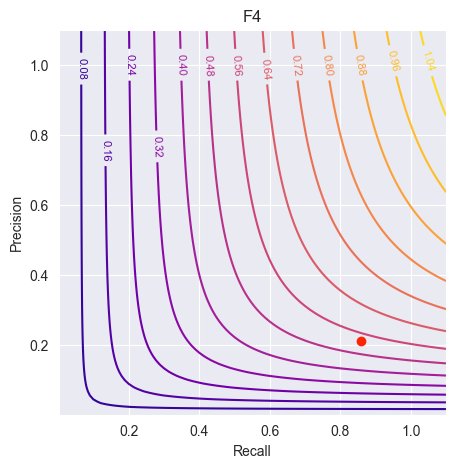

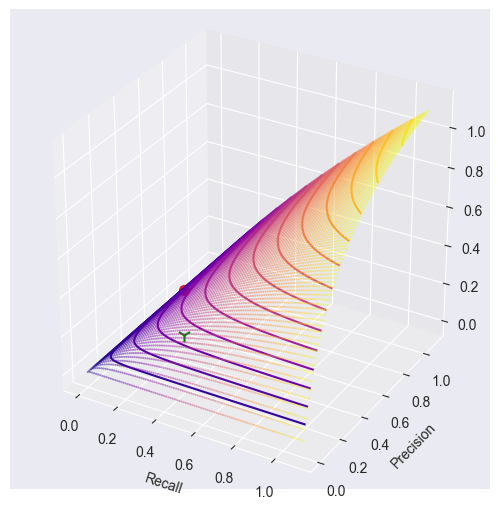

In [393]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here


f4 = lambda x, y: (5 * x * y) / (x + 4 * y)

f4_idx = (f4(recall, precision)).argmax()

print(f"Precision:\t {precision[f4_idx].round(3)}")
print(f"Recall: \t {recall[f4_idx].round(3)}")
print(f"Threshold:\t {threshold[f4_idx].round(3)}")
print(f"F-4:\t {f4(recall, precision)[f4_idx].round(3)}")

level_lines(f4, "F4")
plt.plot(recall[f4_idx], precision[f4_idx], color='#FF2400', marker='o')

plot_3d(f4, recall, precision)